In [69]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import layers

In [3]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

# CLEAN UP MEMORY
gc.collect()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


22

In [4]:
#READ DATA FROM FILE
dataset=pd.read_csv("C:/ProgramData/ETH/TrainingData/training.csv", sep=',',header=0)

In [5]:
#PRINT DATA
print(dataset)

             close        date        high         low        open  \
0       515.609375  1527552000  515.609375  512.633685  512.633685   
1       514.018489  1527552300  514.832422  513.291775  513.291775   
2       514.758432  1527552600  514.758432  514.290853  514.546926   
3       513.794384  1527552900  515.055799  513.794384  514.042601   
4       515.085181  1527553200  516.370237  515.085181  515.457029   
...            ...         ...         ...         ...         ...   
169678  153.050617  1587010800  153.050617  152.854924  152.854924   
169679  152.752155  1587011100  153.006762  152.752155  153.006762   
169680  152.439027  1587011400  152.821772  152.439027  152.744516   
169681  152.565608  1587011700  152.619371  152.429768  152.429768   
169682  152.619000  1587012000  152.619000  152.467567  152.493479   

        quoteVolume        volume  weightedAverage  
0         93.446187  48034.930402       514.038418  
1          1.658992    854.079129       514.818062  


In [6]:
#CONDUCT PEARSON CORRELATION
correlation_matrix = dataset.corr()
print(correlation_matrix)

                    close      date      high       low      open  \
close            1.000000 -0.508373  0.999990  0.999990  0.999984   
date            -0.508373  1.000000 -0.508153 -0.508644 -0.508391   
high             0.999990 -0.508153  1.000000  0.999979  0.999990   
low              0.999990 -0.508644  0.999979  1.000000  0.999989   
open             0.999984 -0.508391  0.999990  0.999989  1.000000   
quoteVolume     -0.097158  0.265288 -0.095563 -0.098753 -0.096949   
volume           0.013223  0.200600  0.014927  0.011517  0.013439   
weightedAverage  0.999995 -0.508401  0.999994  0.999994  0.999993   

                 quoteVolume    volume  weightedAverage  
close              -0.097158  0.013223         0.999995  
date                0.265288  0.200600        -0.508401  
high               -0.095563  0.014927         0.999994  
low                -0.098753  0.011517         0.999994  
open               -0.096949  0.013439         0.999993  
quoteVolume         1.000000  

<AxesSubplot:>

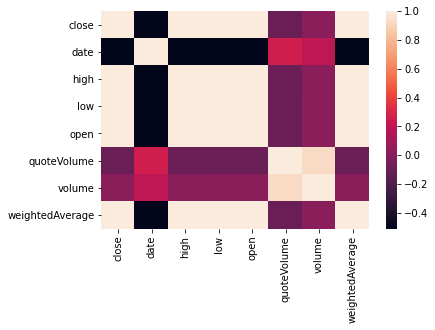

In [7]:
# plot the heatmap
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

In [19]:
#SELECT FEATURES AND TAGET
data = dataset[["high","low","open","weightedAverage", "close"]]
#data = data.values
#data = data.astype('float32')
print(data)

              high         low        open  weightedAverage       close
0       515.609375  512.633685  512.633685       514.038418  515.609375
1       514.832422  513.291775  513.291775       514.818062  514.018489
2       514.758432  514.290853  514.546926       514.605286  514.758432
3       515.055799  513.794384  514.042601       514.191683  513.794384
4       516.370237  515.085181  515.457029       515.591183  515.085181
...            ...         ...         ...              ...         ...
169678  153.050617  152.854924  152.854924       152.886919  153.050617
169679  153.006762  152.752155  153.006762       152.939893  152.752155
169680  152.821772  152.439027  152.744516       152.759464  152.439027
169681  152.619371  152.429768  152.429768       152.610503  152.565608
169682  152.619000  152.467567  152.493479       152.555719  152.619000

[169683 rows x 5 columns]


In [20]:
#SCALE DATA 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [56]:
#DEFINE MODEL CREATION METHOD. ENABLES EASY HYPER PARAM TUNING
def build_model(inputs, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    
    model = models.Sequential()
    model.add(layers.LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(units=inputs.shape[2]))
    #model.add(layers.Dense(units=1))
    model.add(layers.Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [22]:
def split_data(training_split, data):
    # split into train and test sets
    train_size = int(len(data) * training_split)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return (train, test)

In [49]:
def split_sequences_multivariate_output(sequences, look_back):
    x, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + look_back
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern; need to parameterize for different number of columns
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        x.append(seq_x)
        y.append(seq_y)
            
    return np.array(x), np.array(y)

In [88]:
#INIT HYPER PARAMS
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 0.2
batch_size = 12
epochs = 53
#epochs = 1
training_split = 0.8
look_back = 6

In [89]:
#SPLIT DATA FOR TRAINING
train_data, test_data = split_data(training_split, data)

In [90]:
#SHAPE DATA FOR LSTM INPUT
x_train, y_train = split_sequences_multivariate_output(train_data, look_back)
x_test, y_test = split_sequences_multivariate_output(test_data, look_back)

#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (135740, 6, 5).
training targets shape == (135740, 5).
testing features shape == (33931, 6, 5).
testing features shape == (33931, 5).
X_TRAIN
[[[0.79381908 0.79306201 0.78975707 0.79399787 0.7947809 ]
  [0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]]

 [[0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]
  [0.79286119 0.79757885 0.79425509 0.79592379 0.79382207]]

 [[0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
 

In [91]:
y_train =  np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test =  np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [92]:
#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (135740, 6, 5).
training targets shape == (135740, 1, 5).
testing features shape == (33931, 6, 5).
testing features shape == (33931, 1, 5).
X_TRAIN
[[[0.79381908 0.79306201 0.78975707 0.79399787 0.7947809 ]
  [0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]]

 [[0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]
  [0.79286119 0.79757885 0.79425509 0.79592379 0.79382207]]

 [[0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145

In [93]:
# CLEAN UP MEMORY
gc.collect()
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
model = build_model(x_train, neurons=neurons)
# train model on data
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test), shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 512)            1060864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 512)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6, 5)              2565      
_________________________________________________________________
activation_3 (Activation)    (None, 6, 5)              0         
Total params: 1,063,429
Trainable params: 1,063,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/53
11312/11312 [==============================] - 51s 4ms/step - loss: 0.0049 - mae: 0.0259 - val_loss: 0.0069 - val_mae: 0.0721
Epoch 2/53
11312/11312 [==============================] - 50s 4ms/step - loss: 0.0017 - mae: 0.0157 - val

Epoch 53/53
11312/11312 [==============================] - 50s 4ms/step - loss: 1.9040e-04 - mae: 0.0072 - val_loss: 0.0019 - val_mae: 0.0390


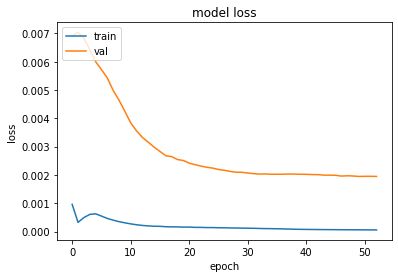

In [94]:
#PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

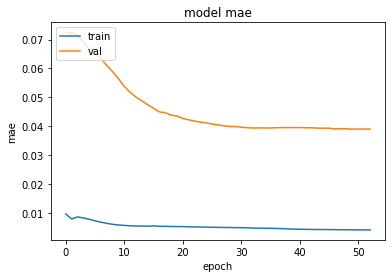

In [95]:
#PLOT LOSS
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
#PERFORM PREDICTIONS
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict.shape)
print(test_predict.shape)

#WHY IS IT PREDICTING 6 OUTCOMES. IS IT BECAUSE PROVIDING DATA IN THAT FORMAT? NEED TO PROVIDE FLAT DATA?

(135740, 6, 5)
(33931, 6, 5)


In [124]:
test_predict_shaped = scaler.inverse_transform(np.array(test_predict)[:, 0])
train_predict_shaped = scaler.inverse_transform(np.array(train_predict)[:, 0])
test_predict_shaped = test_predict_shaped[:,4:5]
train_predict_shaped = train_predict_shaped[:,4:5]
print(test_predict_shaped.shape)
print(train_predict_shaped.shape)

(33931, 1)
(135740, 1)


In [125]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[:,0,4], train_predict[:,0,4]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test[:,0,4], test_predict[:,0,4]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.09 RMSE
Test Score: 0.04 RMSE


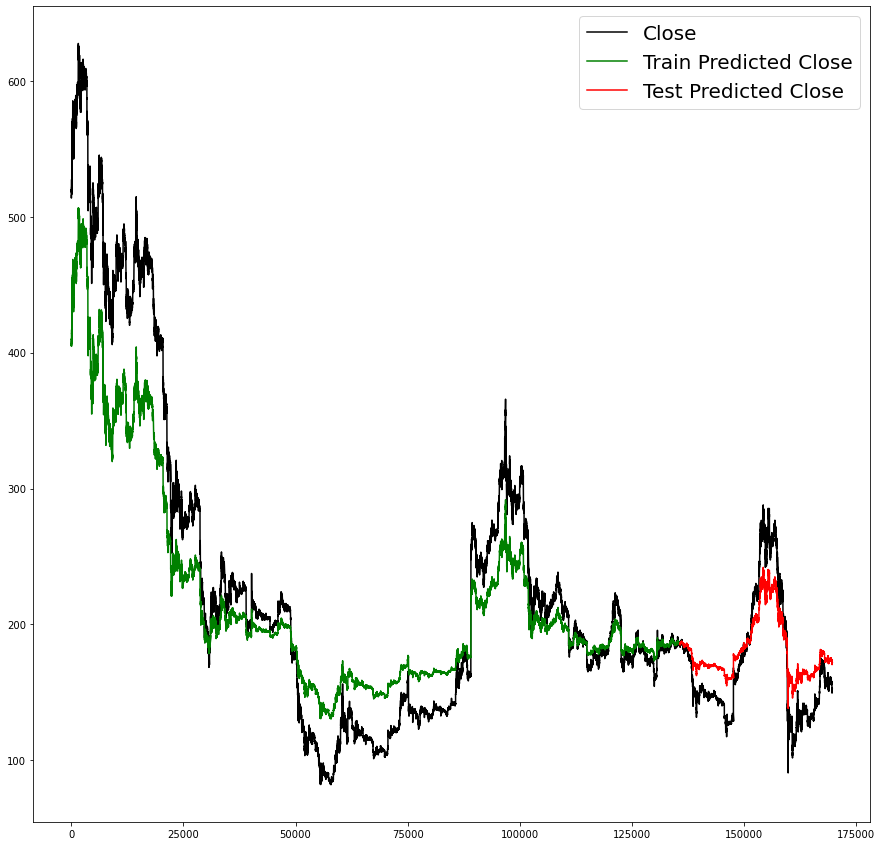

In [136]:

baseData = scaler.inverse_transform(data)[:, 4:5]
# shift train predictions for plotting
trainPredictPlot = np.empty_like(baseData)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_shaped)+look_back, :] = train_predict_shaped
# shift test predictions for plotting
testPredictPlot = np.empty_like(baseData)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_shaped)+(look_back*2)+1:len(baseData)-1, :] = test_predict_shaped[0:33929, :]
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseData, '-', color='k', label='Close')
plt.plot(trainPredictPlot, '-', color='g', label='Train Predicted Close')
plt.plot(testPredictPlot, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()